<a href="https://colab.research.google.com/github/Migol123/K-IMU/blob/main/k-IMU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%pip install tensorboard
%pip install stable-baselines3
%pip install gymnasium
%pip install shimmy
%pip install torch
%pip install stable-baselines3 gym


Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import networkx as nx
from math import sqrt

In [4]:
def generador_data(fac, dem, deman_max):
    ancho = 2500
    cor_dem = [(random.randint(1, ancho), random.randint(1, ancho)) for _ in range(dem)]
    dem_p = [random.randint(1, deman_max) for _ in range(dem)]  # Tamaño de puntos escalado para visualización

    cor_fac = [(random.randint(1, ancho), random.randint(1, ancho)) for _ in range(fac)]

    # Crear el grafo
    G = nx.Graph()

    # Añadir nodos de demanda y facilidad al grafo
    for i, coord in enumerate(cor_dem):
        G.add_node(f"D{i}", pos=coord, demand=dem_p[i], color='red', size=dem_p[i])

    for j, coord in enumerate(cor_fac):
        G.add_node(f"F{j}", pos=coord, color='blue', size=100)  # Tamaño fijo para facilidades

    # Conectar nodos si cumplen una condición específica (e.g., todos conectados)
    cover=[]
    for i, c_dem in enumerate(cor_dem):
        for j, c_fac in enumerate(cor_fac):
            # Conectar si la distancia es menor a un umbral, ajustar según necesidad
            if sqrt((c_dem[0] - c_fac[0]) ** 2 + (c_dem[1] - c_fac[1]) ** 2) < 500:
                cover.append(1)
                G.add_edge(f"D{i}", f"F{j}")
            else:
                cover.append(0)

    cover=m_cover=pd.DataFrame(np.array(cover).reshape(fac,dem))
    # Establecer el tamaño de la figura (ancho x alto en pulgadas)
    plt.figure(figsize=(15, 15))  # Ajuste del tamaño de la figura a 15x15 pulgadas
    pos = nx.get_node_attributes(G, 'pos')
    colors = [G.nodes[node]['color'] for node in G.nodes]
    sizes = [G.nodes[node]['size'] for node in G.nodes]

    nx.draw(G, pos, node_color=colors, node_size=sizes, with_labels=False, edge_color='gray', alpha=0.6)
    plt.title('Red de Puntos de Demanda y Facilidades')
    plt.show()
    return dem_p,cover


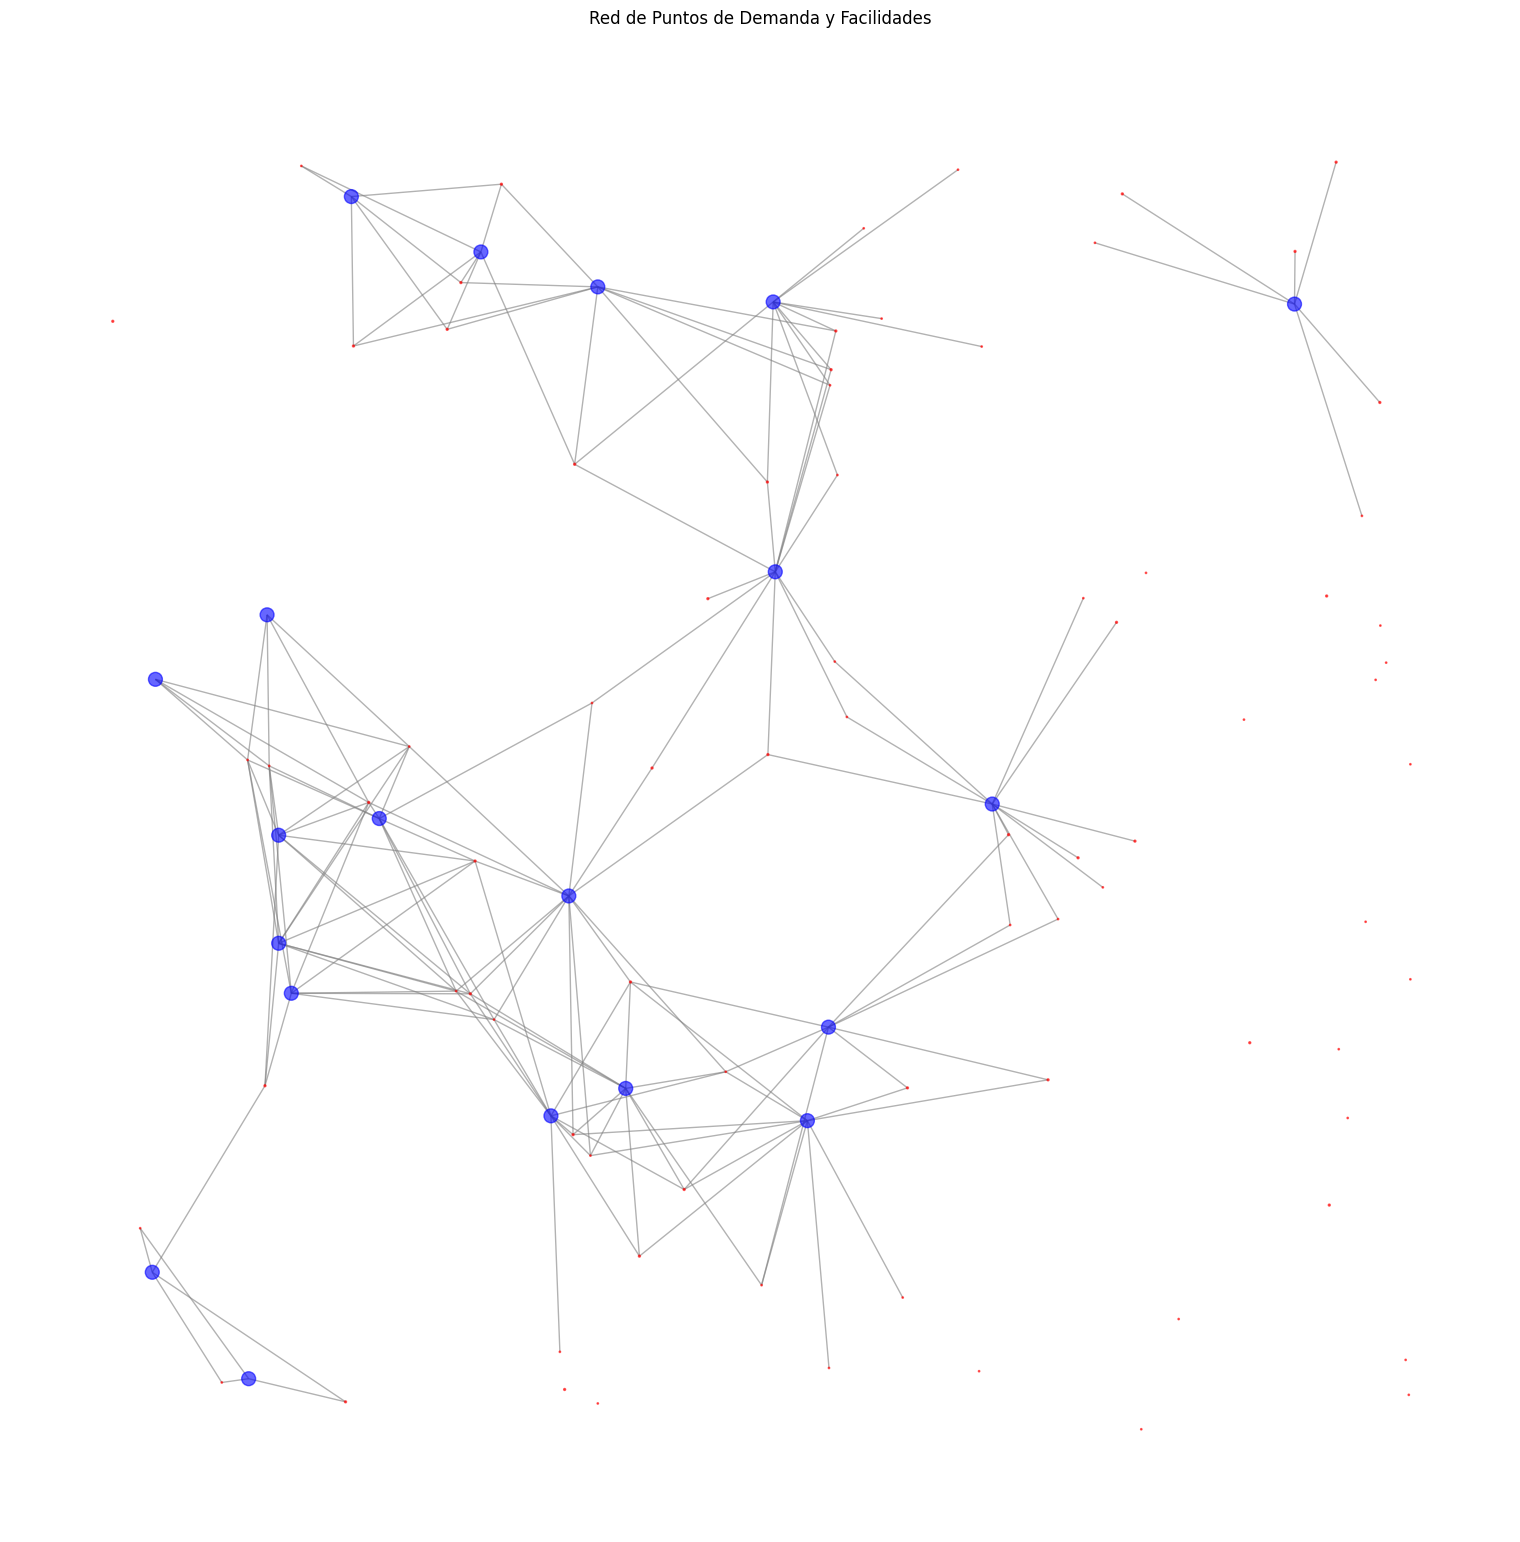

115


In [5]:
fac=20
demp=80
deman_max=2
m_demp,m_cover=generador_data(fac, demp, deman_max)
print(np.array(m_demp).sum())

In [6]:
fac
demp
deman_max
m_demp
m_cover
num_days=5
max_installations_per_facility=6
print()

In [7]:
import gym
from gym import spaces
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.animation as animation

class HumanitarianFacilityLocationEnv(gym.Env):
    """Un entorno para modelar la ubicación de facilidades en situaciones humanitarias."""

    def __init__(self, num_demand_points, num_facilities, num_days, coverage_matrix, demand_matrix, 
                 max_installations_per_facility=5, max_capacity_per_facility=500, max_total_installations=100):
        super(HumanitarianFacilityLocationEnv, self).__init__()
        self.num_demand_points = num_demand_points
        self.num_facilities = num_facilities
        self.num_days = num_days
        self.coverage_matrix = np.array(coverage_matrix, dtype=np.int32)
        self.demand_matrix = np.array(demand_matrix, dtype=np.int32)
        self.max_installations_per_facility = max_installations_per_facility
        self.max_capacity_per_facility = max_capacity_per_facility
        self.max_total_installations = max_total_installations
        self.installations_per_facility = np.zeros(num_facilities, dtype=int)
        self.available_installations = max_total_installations

        # Definir el espacio de acción, ajustado para reflejar la nueva estrategia de colocar y retirar tiendas
        # Ahora usando Box
        self.action_space = spaces.Box(low=-self.max_installations_per_facility,
                                       high=self.max_installations_per_facility,
                                       shape=(self.num_facilities,),
                                       dtype=np.int32)

        # Definir el espacio de observación
        self.observation_space = spaces.Box(low=0, 
                                            high=max_capacity_per_facility * max_installations_per_facility,
                                            shape=(self.num_demand_points,), 
                                            dtype=np.int32)
        self.state = self.update_coverage()

        # Matrices para almacenar la información de las tiendas y su cobertura
        self.daily_store_info = []  # Una lista de matrices para cada día, donde cada fila representa una tienda
        self.daily_coverage_matrix = []  # Una lista de matrices para cada día, donde cada fila representa la cobertura de una tienda


    def update_coverage(self):
        coverage_effective = np.zeros(self.num_demand_points)
        for fac in range(self.num_facilities):
            installation_effect = self.installations_per_facility[fac] * self.max_capacity_per_facility
            coverage_effective += self.coverage_matrix[fac] * installation_effect
        self.state = np.maximum(self.demand_matrix - coverage_effective, 0)
        return self.state

    def step(self, actions):
        reward = 0
        for fac_idx, change in enumerate(actions):
            # Asegurarse de que las acciones no excedan los límites
            change = np.clip(change, -self.installations_per_facility[fac_idx], 
                            self.max_installations_per_facility - self.installations_per_facility[fac_idx])
            self.installations_per_facility[fac_idx] += change
            self.available_installations -= change

        self.state = self.update_coverage()
        reward = self.calculate_reward()
        done = self.current_day >= self.num_days or self.available_installations == 0
        info = {"info": "Some info if needed", "total_cost": self._calculate_total_cost()}
        return self.state, reward, done, info

    def reset(self):
        self.current_day = 0
        self.installations_per_facility.fill(0)
        self.available_installations = self.max_total_installations
        self.state = self.update_coverage()
        return self.state

    def calculate_reward(self):
        # Recompensa por demanda cubierta
        coverage_reward = 500 * np.sum(np.minimum(self.state, self.demand_matrix))
        return coverage_reward

    def _calculate_total_cost(self):
        # Penalización por demanda no atendida
        unmet_demand_penalty = 10000 * np.sum(np.maximum(self.demand_matrix - self.state, 0))
        # Costo de instalación
        installation_cost = 1000 * np.sum(self.installations_per_facility)
        # Costo total es la penalización menos los incentivos
        total_cost = unmet_demand_penalty + installation_cost
        return total_cost

# Implementación de Q-Learning
class QLearningAgent:
    def __init__(self, env, alpha=0.1, gamma=0.9, epsilon=0.1, num_intervals=10):
        self.env = env
        self.alpha = alpha  # Tasa de aprendizaje
        self.gamma = gamma  # Factor de descuento
        self.epsilon = epsilon  # Probabilidad de exploración
        self.num_intervals = num_intervals
        self.observation_intervals = np.linspace(0, env.observation_space.high[0], num_intervals)

        # Ahora la tabla Q es un array multidimensional
        # Asegurándote de que el tamaño sea manejable
        self.q_table = np.zeros((num_intervals, *[10] * env.num_facilities))  # Crea la tabla Q

    def get_state_index(self, state):
        # Encuentra el índice del intervalo al que pertenece el estado
        state_index = np.clip(state[0], self.observation_intervals[0], self.observation_intervals[-1])
        interval_index = np.searchsorted(self.observation_intervals, state_index)
        return interval_index

    def choose_action(self, state):
        state_index = self.get_state_index(state)  # Obtén el índice del estado discreto
        if np.random.rand() < self.epsilon:
            # Exploración: elegir una acción aleatoria
            return self.env.action_space.sample()
        else:
            # Explotación: elegir la acción con el valor Q más alto
            # Primero discretiza el estado para indexar en la tabla Q
            discretized_state = np.clip(state, self.observation_intervals[0], self.observation_intervals[-1])
            discretized_state_indices = np.searchsorted(self.observation_intervals, discretized_state)
            
            # Obtener las acciones con los valores Q más altos para cada instalación
            actions = []
            for fac_idx in range(self.env.num_facilities):
                action_values = self.q_table[discretized_state_indices[0], fac_idx, :].reshape(-1)  # Asegúrate de que esto tiene la forma correcta
                max_index = np.argmax(action_values)
                action = max_index - 5  # Ajusta el índice para que esté dentro del rango de acción
                actions.append(action)
            return np.array(actions, dtype=np.int32)

    def update_q_table(self, state, action, reward, next_state, done):
        state_index = self.get_state_index(state)
        next_state_index = self.get_state_index(next_state)
        # Actualiza la tabla Q usando la ecuación de Q-Learning
        # Discretiza el estado para indexar en la tabla Q
        discretized_state = np.clip(state, self.observation_intervals[0], self.observation_intervals[-1])
        discretized_state_indices = np.searchsorted(self.observation_intervals, discretized_state)
        # Actualizar la tabla Q
        self.q_table[discretized_state_indices[0], *action] += self.alpha * (reward + self.gamma * np.max(self.q_table[next_state_index]) - self.q_table[discretized_state_indices[0], *action])

# Entrenar al agente
env = HumanitarianFacilityLocationEnv(demp, fac, num_days, m_cover, m_demp, max_installations_per_facility)
agent = QLearningAgent(env)


num_episodes = 50000

cost_history = []

epsilon_start = 1.0
epsilon_end = 0.1
epsilon_decay = 0.995
epsilon = epsilon_start  # Establece el epsilon inicial fuera del bucle de episodios

for episode in range(num_episodes):
    state = env.reset()
    done = False
    total_episode_cost = 0 
    while not done:
        if np.random.rand() < epsilon:  # Decisión entre exploración y explotación
            action = env.action_space.sample()
        else:
            action = agent.choose_action(state) 
        next_state, reward, done, info = env.step(action)
        agent.update_q_table(state, action, reward, next_state, done)
        state = next_state
        epsilon = max(epsilon_end, epsilon_decay * epsilon)
        total_episode_cost += info['total_cost'] 

    cost_history.append(total_episode_cost)
    if (episode+1)%1000==0:
        print(f"Episodio {episode+1} - Costo Total: {total_episode_cost}")
        
        
# Visualización del costo total a lo largo de los episodios
plt.figure(figsize=(10, 5))
plt.plot(cost_history)
plt.title("Costo Total por Episodio")
plt.xlabel("Episodio")
plt.ylabel("Costo Total")
plt.grid(True)
plt.show()


# Visualización
def visualize_env(env):
    fig, axs = plt.subplots(3, 1, figsize=(10, 9))

    # Asumiendo que 'demand_matrix' y 'state' pueden ser manipulados para ser 2D si no lo son.
    demand_shape = (1, -1) if env.demand_matrix.ndim == 1 else env.demand_matrix.shape
    state_shape = (1, -1) if env.state.ndim == 1 else env.state.shape

    # Mapa de calor para la demanda
    im_demand = axs[0].imshow(env.demand_matrix.reshape(demand_shape), cmap='viridis', interpolation='nearest')
    fig.colorbar(im_demand, ax=axs[0], orientation='vertical')
    axs[0].set_title("Demanda")
    axs[0].set_xlabel("Puntos de Demanda")
    axs[0].set_ylabel("Tiempo")

    # Mapa de calor para la cobertura
    im_coverage = axs[1].imshow(env.state.reshape(state_shape), cmap='viridis', interpolation='nearest')
    fig.colorbar(im_coverage, ax=axs[1], orientation='vertical')
    axs[1].set_title("Cobertura")
    axs[1].set_xlabel("Puntos de Demanda")
    axs[1].set_ylabel("Tiempo")

    # Mapa de calor para las tiendas y su cobertura
    im_stores = axs[2].imshow(np.sum(env.daily_coverage_matrix, axis=0), cmap='viridis', interpolation='nearest')
    fig.colorbar(im_stores, ax=axs[2], orientation='vertical')
    axs[2].set_title("Tiendas y Cobertura")
    axs[2].set_xlabel("Puntos de Demanda")
    axs[2].set_ylabel("Ubicación de la Tienda")

    # Mostrar información de las acciones diarias
    for day, daily_actions in enumerate(env.daily_store_info):
        print(f"Día {day+1}:")
        for facility_index, action in enumerate(daily_actions):
            if action == "Instalar":
                print(f"Instalación {facility_index+1}: Instalado")
            elif action == "Mover":
                print(f"Instalación {facility_index+1}: Movido")
            elif action == "Retirar":
                print(f"Instalación {facility_index+1}: Retirado")
            else:
                print(f"Instalación {facility_index+1}: No hacer nada")

    plt.tight_layout()
    plt.show()

# Ejecutar la visualización
env = HumanitarianFacilityLocationEnv(demp, fac, num_days, m_cover, m_demp, max_installations_per_facility)
visualize_env(env)

ValueError: array is too big; `arr.size * arr.dtype.itemsize` is larger than the maximum possible size.

In [ ]:
import gym
from gym import spaces
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.animation as animation

class HumanitarianFacilityLocationEnv(gym.Env):
    """Un entorno para modelar la ubicación de facilidades en situaciones humanitarias."""

    def __init__(self, num_demand_points, num_facilities, num_days, coverage_matrix, demand_matrix, max_installations_per_facility=5, max_capacity_per_facility=500, max_total_installations=100):
        super(HumanitarianFacilityLocationEnv, self).__init__()
        self.num_demand_points = num_demand_points
        self.num_facilities = num_facilities
        self.num_days = num_days
        self.coverage_matrix = np.array(coverage_matrix, dtype=np.int32)
        self.demand_matrix = np.array(demand_matrix, dtype=np.int32)
        self.max_installations_per_facility = max_installations_per_facility
        self.max_capacity_per_facility = max_capacity_per_facility
        self.max_total_installations = max_total_installations
        self.installations_per_facility = np.zeros(num_facilities, dtype=int)
        self.available_installations = max_total_installations

        # Definir el espacio de acción, ajustado para reflejar la nueva estrategia de colocar y retirar tiendas
        self.action_space = spaces.Box(low=-self.max_installations_per_facility,
                                       high=self.max_installations_per_facility,
                                       shape=(self.num_facilities,),
                                       dtype=np.int32)

        # Definir el espacio de observación
        self.observation_space = spaces.Box(low=0, 
                                            high=max_capacity_per_facility * max_installations_per_facility,
                                            shape=(self.num_demand_points,), 
                                            dtype=np.int32)
        self.state = self.update_coverage()

        # Matrices para almacenar la información de las tiendas y su cobertura
        self.daily_store_info = []  # Una lista de matrices para cada día, donde cada fila representa una tienda
        self.daily_coverage_matrix = []  # Una lista de matrices para cada día, donde cada fila representa la cobertura de una tienda


    def update_coverage(self):
        coverage_effective = np.zeros(self.num_demand_points)
        for fac in range(self.num_facilities):
            installation_effect = self.installations_per_facility[fac] * self.max_capacity_per_facility
            coverage_effective += self.coverage_matrix[fac] * installation_effect
        self.state = np.maximum(self.demand_matrix - coverage_effective, 0)
        return self.state

    def step(self, actions):
        reward = 0
        for fac_idx, change in enumerate(actions):
            if change > 0:
                # Intentar agregar tiendas
                possible_additions = min(change, self.max_installations_per_facility - self.installations_per_facility[fac_idx])
                self.installations_per_facility[fac_idx] += possible_additions
                self.available_installations -= possible_additions
                # Puede haber una recompensa por agregar tiendas, por ejemplo, basada en la cobertura aumentada
            elif change < 0:
                # Intentar retirar tiendas
                possible_removals = min(-change, self.installations_per_facility[fac_idx])
                self.installations_per_facility[fac_idx] -= possible_removals
                self.available_installations += possible_removals
                # Puede haber una penalización o recompensa por retirar tiendas

        self.state = self.update_coverage()
        reward = self.calculate_reward()  # Definir esta función según tus criterios
        done = self.current_day >= self.num_days or self.available_installations == 0
        info = {"info": "Some info if needed"}
        return self.state, reward, done, info




    def reset(self):
        self.current_day = 0
        self.installations_per_facility.fill(0)
        self.available_installations = self.max_total_installations
        self.state = self.update_coverage()
        return self.state



    def _calculate_total_cost(self):
        # Penalización por demanda no atendida (aumentada)
        unmet_demand_penalty = 5000 * np.sum(self.demand_matrix - self.state)
        # Costo de instalación (agregado)
        installation_cost = 500 * np.sum(self.installations_per_facility > 0)
        return unmet_demand_penalty + installation_cost

# Implementación de Q-Learning
class QLearningAgent:
    def __init__(self, env, alpha=0.1, gamma=0.9, epsilon=0.1, num_intervals=10):
        self.env = env
        self.alpha = alpha  # Tasa de aprendizaje
        self.gamma = gamma  # Factor de descuento
        self.epsilon = epsilon  # Probabilidad de exploración
        self.num_intervals = num_intervals
        self.observation_intervals = np.linspace(0, env.observation_space.high[0], num_intervals)

        # Crea la tabla Q con las dimensiones correctas para el espacio de acción MultiDiscrete
        self.q_table = np.zeros((num_intervals, env.action_space.nvec[0], env.action_space.nvec[1]))

    def get_state_index(self, state):
        # Encuentra el índice del intervalo al que pertenece el estado
        state_index = np.clip(state[0], self.observation_intervals[0], self.observation_intervals[-1])
        interval_index = np.searchsorted(self.observation_intervals, state_index)
        return interval_index

    def choose_action(self, state):
        state_index = self.get_state_index(state)  # Obtén el índice del estado discreto
        if np.random.rand() < self.epsilon:
            # Exploración: elegir una acción aleatoria
            return self.env.action_space.sample()
        else:
            # Explotación: elegir la acción con el valor Q más alto
            action_values = self.q_table[state_index].reshape(-1)  # Asegúrate de que esto tiene la forma correcta
            max_index = np.argmax(action_values)
            # Convertir el índice lineal a índices multidimensionales
            origin_index = max_index // (self.env.num_facilities * 4)
            rest = max_index % (self.env.num_facilities * 4)
            destination_index = rest // 4
            action_type = rest % 4
            return (origin_index, destination_index, action_type)




    def update_q_table(self, state, action, reward, next_state, done):
        state_index = self.get_state_index(state)
        next_state_index = self.get_state_index(next_state)
        # Actualiza la tabla Q usando la ecuación de Q-Learning
        self.q_table[state_index, action[0], action[1]] += self.alpha * (reward + self.gamma * np.max(self.q_table[next_state_index]) - self.q_table[state_index, action[0], action[1]])

    def _calculate_total_cost(self):
        # Penalización por demanda no atendida, ahora más severa
        unmet_demand_penalty = 10000 * np.sum(np.maximum(self.demand_matrix - self.state, 0))

        # Costo de instalación, con un costo adicional por número de tiendas
        installation_cost = 1000 * np.sum(self.installations_per_facility)

        # Recompensa por demanda cubierta (incentivo)
        coverage_reward = 500 * np.sum(np.minimum(self.state, self.demand_matrix))

        # Costo total es la penalización menos los incentivos
        total_cost = unmet_demand_penalty + installation_cost - coverage_reward

        return total_cost



# Entrenar al agente
env = HumanitarianFacilityLocationEnv(demp, fac, num_days, m_cover, m_demp, max_installations_per_facility)
agent = QLearningAgent(env)


num_episodes = 50000

cost_history = []

epsilon_start = 1.0
epsilon_end = 0.1
epsilon_decay = 0.995
epsilon = epsilon_start  # Establece el epsilon inicial fuera del bucle de episodios

for episode in range(num_episodes):
    state = env.reset()
    done = False
    total_episode_cost = 0  # Asegúrate de que esta es la variable correctamente nombrada
    while not done:
        if np.random.rand() < epsilon:  # Decisión entre exploración y explotación
            action = env.action_space.sample()
        else:
            action = agent.choose_action(state)  # Esta función ya debería elegir la mejor acción basada en Q-table
        next_state, reward, done, info = env.step(action)
        agent.update_q_table(state, action, reward, next_state, done)
        state = next_state
        
        # Decaimiento de epsilon después de cada episodio
        epsilon = max(epsilon_end, epsilon_decay * epsilon)
        total_episode_cost += info['total_cost']  # Aquí también asegúrate de que el nombre es correcto

    cost_history.append(total_episode_cost)
    #if (episode+1)%1000==0:
    print(f"Episodio {episode+1} - Costo Total: {total_episode_cost}")
        #print(f"Episodio {episode+1} - Recompensa: {reward}")
        
        #print(f"Acción elegida: {action}")  # Muestra qué acción se ha elegido
        #print(f"Estado después de la acción: {next_state}")  # Muestra el estado después de la acción

# Visualización del costo total a lo largo de los episodios
plt.figure(figsize=(10, 5))
plt.plot(cost_history)
plt.title("Costo Total por Episodio")
plt.xlabel("Episodio")
plt.ylabel("Costo Total")
plt.grid(True)
plt.show()


# Visualización
def visualize_env(env):
    fig, axs = plt.subplots(3, 1, figsize=(10, 9))

    # Asumiendo que 'demand_matrix' y 'state' pueden ser manipulados para ser 2D si no lo son.
    demand_shape = (1, -1) if env.demand_matrix.ndim == 1 else env.demand_matrix.shape
    state_shape = (1, -1) if env.state.ndim == 1 else env.state.shape

    # Mapa de calor para la demanda
    im_demand = axs[0].imshow(env.demand_matrix.reshape(demand_shape), cmap='viridis', interpolation='nearest')
    fig.colorbar(im_demand, ax=axs[0], orientation='vertical')
    axs[0].set_title("Demanda")
    axs[0].set_xlabel("Puntos de Demanda")
    axs[0].set_ylabel("Tiempo")

    # Mapa de calor para la cobertura
    im_coverage = axs[1].imshow(env.state.reshape(state_shape), cmap='viridis', interpolation='nearest')
    fig.colorbar(im_coverage, ax=axs[1], orientation='vertical')
    axs[1].set_title("Cobertura")
    axs[1].set_xlabel("Puntos de Demanda")
    axs[1].set_ylabel("Tiempo")

    # Mapa de calor para las tiendas y su cobertura
    im_stores = axs[2].imshow(np.sum(env.daily_coverage_matrix, axis=0), cmap='viridis', interpolation='nearest')
    fig.colorbar(im_stores, ax=axs[2], orientation='vertical')
    axs[2].set_title("Tiendas y Cobertura")
    axs[2].set_xlabel("Puntos de Demanda")
    axs[2].set_ylabel("Ubicación de la Tienda")

    # Mostrar información de las acciones diarias
    for day, daily_actions in enumerate(env.daily_store_info):
        print(f"Día {day+1}:")
        for facility_index, action in enumerate(daily_actions):
            if action == "Instalar":
                print(f"Instalación {facility_index+1}: Instalado")
            elif action == "Mover":
                print(f"Instalación {facility_index+1}: Movido")
            elif action == "Retirar":
                print(f"Instalación {facility_index+1}: Retirado")
            else:
                print(f"Instalación {facility_index+1}: No hacer nada")

    plt.tight_layout()
    plt.show()

# Ejecutar la visualización
env = HumanitarianFacilityLocationEnv(demp, fac, num_days, m_cover, m_demp, max_installations_per_facility)
visualize_env(env)

AttributeError: 'Box' object has no attribute 'nvec'